# Extracting symbols from image using `OpenCV`

In [2]:
import os
import pickle
import cv2
import numpy as np
from functools import cmp_to_key
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import tensorflow as tf

from tensorflow import keras
%matplotlib inline 
import matplotlib.pyplot as plt

In [3]:
def extractSymbols(imgOrig, showSteps = False):
    debugImgSteps = []
    imgGray = cv2.cvtColor(imgOrig,cv2.COLOR_BGR2GRAY)
    imgFiltered = cv2.medianBlur(imgGray, 5)
    debugImgSteps.append(imgFiltered)
    
    imgCanny = cv2.Canny(imgFiltered, 50,180)
    debugImgSteps.append(imgCanny)

    kernel = np.ones((5,5), np.uint8)
    imgDilated = cv2.dilate(imgCanny, kernel, iterations=5)
    debugImgSteps.append(imgDilated)

    contours, _= cv2.findContours(imgDilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    boundingBoxes = []
    for contour in contours:
        x,y,w,h = cv2.boundingRect(contour)
        boundingBoxes.append((x,y,w,h))

    global rowsG
    rowsG, _, _ = imgOrig.shape
    key_leftRightTopBottom = cmp_to_key(leftRightTopBottom)
    boundingBoxes = sorted(boundingBoxes, key=key_leftRightTopBottom)

    symbols = []
    for (i, box) in enumerate(boundingBoxes):
        x,y,w,h = box
        mathSymbol = imgOrig[y:y+h, x:x+w]
        mathSymbol = cv2.cvtColor(mathSymbol, cv2.COLOR_BGR2GRAY) #converting to Gray as tensorflow deals with grayscale or RGB, not BGR
        mathSymbol = cv2.resize(mathSymbol, (45,45), interpolation=cv2.INTER_AREA) #to have the same size as trained images in the dataset
        debugImgSteps.append(mathSymbol)
        mathSymbolF = mathSymbol.astype('float32') #optional: tensorflows deals with float32, not uint8
        tf.keras.utils.normalize(mathSymbolF, axis=1)
        symbols.append(mathSymbolF)

    if showSteps:
        dispImages(debugImgSteps)

    return symbols
        

In [4]:
def leftRightTopBottom(tup1, tup2):
    x1, y1, _, _ = tup1
    x2, y2, _, _ = tup2
    rows = rowsG
    yRegion1, yRegion2 = -1, -1

    for i in range(4):
        if y1 < rows/4 + rows*(i/4):
            yRegion1 = i
            break
    else:
        if yRegion1 == -1:
            yRegion1 = 4

    for i in range(4):
        if y2 < rows/4 + rows*(i/4):
            yRegion2 = i
            break
    else:
        if yRegion2 == -1:
            yRegion2 = 4
    
    if yRegion1 < yRegion2:
        return -1
    elif yRegion2 < yRegion1:
        return 1
    elif x1 <= x2:
        return -1
    else:
        return 1


In [5]:
def dispImages(imgs):
    for img in imgs:
        cv2.imshow('Image', img)
        cv2.waitKey(0)
    else:
        cv2.destroyAllWindows()

In [5]:
img = cv2.imread('tests/test16.png')
symbols = extractSymbols(img, showSteps=True)

In [6]:
dispImages(symbols)

# Creating dictionary that maps folder names to latex

example of folder names in "mathSymbolsDataset": <br>
<img src="guideImages/datasetFolders.png" width=400 height=300>

using `r` to make the string `raw` to avoid confusing strings like `\n` with python's new line <br>
however, the values will now have two backslashes (e.g. `\\n`), thus, we will later need to replace each `\\` with `\`

In [6]:
dic = {
    "-": r"-",
    "(": r"(",
    ")": r")",   
    "+": r"+",
    "=": r"=",
    "0": r"0",
    "1": r"1",
    "2": r"2",
    "3": r"3",
    "4": r"4",
    "5": r"5",
    "6": r"6",
    "7": r"7",
    "8": r"8",
    "9": r"9",
    
    "geq": r"\geq",
    "gt": r">",
    "i": r"i",
    "in": r"\in",
    "int": r"\int",
    "j": r"j",

    "leq": r"\le",

    "lt": r"<",
    
    "neq": r"\neq",
    
    "pi": r"\Pi",
    
    "sum": r"\sum",
    "theta": r"\theta",
    "times": r"\times",

    "w": r"w",
    "X": r"\X",
    "y": r"y",
    "z": r"z"
}

# Preparing the dataset

## Reading the kaggle [dataset](https://www.kaggle.com/datasets/xainano/handwrittenmathsymbols?resource=download)

Steps:
1. create a list of images and another list of labels for each image
2. store them in pickle files for easy retrieval when re-running the code 

In [10]:
def loadData(dataDir):
    imgs = []
    labels = []
    for key, value in dic.items():
        path = os.path.join(dataDir, key)
        print(path)
        for imgName in os.listdir(path):
            try:
                img = cv2.imread(os.path.join(path, imgName), cv2.COLOR_BGR2GRAY) 
                imgs.append(img)
                labels.append(value)
            except Exception as e:
                print(e)    
    return (imgs, labels)

The following cell is commented as it takes a long time (10min if image RGB, 1min otherwise) to create the pickle files

In [11]:
imgs, labels = loadData('mathSymbolsDataset/')

mathSymbolsDataset/-
mathSymbolsDataset/(
mathSymbolsDataset/)
mathSymbolsDataset/+
mathSymbolsDataset/=
mathSymbolsDataset/0
mathSymbolsDataset/1
mathSymbolsDataset/2
mathSymbolsDataset/3
mathSymbolsDataset/4
mathSymbolsDataset/5
mathSymbolsDataset/6
mathSymbolsDataset/7
mathSymbolsDataset/8
mathSymbolsDataset/9
mathSymbolsDataset/geq
mathSymbolsDataset/gt
mathSymbolsDataset/i
mathSymbolsDataset/in
mathSymbolsDataset/int
mathSymbolsDataset/j
mathSymbolsDataset/leq
mathSymbolsDataset/lt
mathSymbolsDataset/neq
mathSymbolsDataset/pi
mathSymbolsDataset/sum
mathSymbolsDataset/theta
mathSymbolsDataset/times
mathSymbolsDataset/w
mathSymbolsDataset/X
mathSymbolsDataset/y
mathSymbolsDataset/z


In [12]:
with open("x_symbols_reduced.pickle", 'wb') as f:
    pickle.dump(imgs, f)
with open("y_latex_reduced.pickle", 'wb') as f:
    pickle.dump(labels, f)

In [7]:
with open("x_symbols_reduced.pickle", 'rb') as f:
    imgs = pickle.load(f)
with open("y_latex_reduced.pickle", 'rb') as f:
    labels = pickle.load(f)

## converting text labels (latex) to numeric codes

In [8]:
latexToNums = {k: v for v, k in enumerate(np.unique(labels))}
#this dictionary is to revert the predicted numeric code back to latex: 
numsToLatex = {v: k for v, k in enumerate(np.unique(labels))}
latexToNums

{'(': 0,
 ')': 1,
 '+': 2,
 '-': 3,
 '0': 4,
 '1': 5,
 '2': 6,
 '3': 7,
 '4': 8,
 '5': 9,
 '6': 10,
 '7': 11,
 '8': 12,
 '9': 13,
 '<': 14,
 '=': 15,
 '>': 16,
 '\\Pi': 17,
 '\\X': 18,
 '\\geq': 19,
 '\\in': 20,
 '\\int': 21,
 '\\le': 22,
 '\\neq': 23,
 '\\sum': 24,
 '\\theta': 25,
 '\\times': 26,
 'i': 27,
 'j': 28,
 'w': 29,
 'y': 30,
 'z': 31}

In [10]:
labelsNums = [latexToNums[label] for label in labels]

## Splitting the data into train and test data

Note that `stratify` is used to split the dataset into train and test sets <br> 
in a way that preserves the same proportions of examples in each class as observed in the original dataset <br>
[(source)](https://machinelearningmastery.com/train-test-split-for-evaluating-machine-learning-algorithms/#:~:text=is%20desirable%20to-,split%20the%20dataset%20into,stratified%20train-test%20split.,-We%20can%20achieve)

In [11]:
x_train, x_test, y_train, y_test = train_test_split(imgs, labelsNums, test_size=0.33, stratify=labelsNums, random_state=42)

## Normalizing image pixels

In [12]:
x_train = tf.keras.utils.normalize(x_train, axis=1) #similar to dividing by 255 (but not equivalent in result)
x_test = tf.keras.utils.normalize(x_test, axis=1) #Also, don't know why we are using "axis=1" specifically, but that's what's normally used with image normalization

### Sanity Check

In [21]:
dispImages([x_train[4]])

In [23]:
numsToLatex[y_train[4]]

'-'

### Making sure all datasets are `ndarray` not `list`
Because `keras` models accept `ndarray`

In [13]:
type(x_train), type(x_test), type(y_train), type(y_test)

(numpy.ndarray, numpy.ndarray, list, list)

In [14]:
y_train = np.array(y_train)
y_test = np.array(y_test)

In [15]:
type(y_train), type(y_test)

(numpy.ndarray, numpy.ndarray)

## Creating the model

### 1. Sequential vs Functional models

* Sequential is a linear stack of layers. In other words, the layer `i` is connected only to layers `i-1` and `i+1`
* Functional is more dynamic, as each layer can connect to any other layer in the neural network

Since the images are small in size, and the problem is relatively simple, we'll use a sequential model

In [27]:
model = tf.keras.models.Sequential()

### 2. Model layers

In [28]:
# for easier processing: flatten image (e.g. 45x45 will become 1x2025)
model.add(tf.keras.layers.Flatten())
# 128 nodes are chosen as they are a power of 2 (2^7) which makes computation easier, and the images are not large (45x45) so 128 nodes should suffice
# relu is the default activation function to use
model.add(tf.keras.layers.Dense(128, activation=tf.nn.relu))
# add another layer because if you have one, then you're getting linear relations only between the image's features, while two layers makes it non-linear
model.add(tf.keras.layers.Dense(128, activation=tf.nn.relu))
# number of classifications == number of stored latex strings == len(latexToNums) == 79
# using softmax as it converts the scores to a normalized probability distribution
model.add(tf.keras.layers.Dense(len(latexToNums), activation=tf.nn.softmax))

### 3. Model compilation

In [ ]:
# "compiling" means passing the settings for actually optimizing/training the model we've defined
model.compile(optimizer='adam', # same logic as relu, great default optimizer to start with
              loss='sparse_categorical_crossentropy', # A neural network doesn't actually attempt to maximize accuracy. It attempts to minimize loss, this loss function is also a great default
              metrics=['accuracy']) # ratio between the number of correct predictions to the total number of predictions.

### 4. Model training

"A good rule of thumb is to start with a value that is 3 times the number of columns in your data." <br>
[(source)](https://gretel.ai/gretel-synthetics-faqs/how-many-epochs-should-i-train-my-model-with) <br>
Therefore, we start by with 45*3 = 135 epochs (i.e. number of passes of the entire training dataset the machine learning algorithm has completed)

In [ ]:
#model.fit(x_train, y_train_nums, epochs=135)

### 5. Save the model for later use

Technical note: pickle doesn't save models correctly, as it outputs this error when loading the pickle file: <br><br>
FileNotFoundError: Unsuccessful TensorSliceReader constructor: Failed to find any matching files for ram://0eb44777-6983-466e-ac15-adfa9d3dae07/variables/variables
 You may be trying to load on a different device from the computational device. Consider setting the `experimental_io_device` option in `tf.saved_model.LoadOptions` to the io_device such as '/job:localhost'. <br><br>
 That's why we are using keras's `save()` and `load_model()`

In [ ]:
#model.save("nnModel")

### 6. Load the model

In [16]:
model = keras.models.load_model("nnModel")

In [17]:
symbols[0].reshape(1,45,45).shape

(1, 45, 45)

In [21]:
symTest = symbols[4]

In [19]:
print(np.argmax(model.predict(symTest.reshape(1,45,45))))

21


In [23]:
from numpy import unique, argmax
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from keras.utils.vis_utils  import plot_model
from matplotlib import pyplot as plt
import numpy as np

In [18]:
model = Sequential()
model.add(Conv2D(32, (3,3), activation  ='relu', input_shape=(45,45,1)))
model.add(MaxPool2D((2,2))) 
#batch normalization, try averagepool
#leak
model.add(Conv2D(48, (3,3), activation='relu'))
model.add(MaxPool2D((2,2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(2025, activation='relu'))
model.add(Dense(79, activation='softmax'))

In [37]:
model.compile(optimizer = 'adam', loss='sparse_categorical_crossentropy', metrics = ['accuracy'])
x = model.fit(x_train, y_train_nums, epochs=10, batch_size=128, verbose=2, validation_split=0.1)

Epoch 1/10
1722/1722 - 386s - loss: 0.6359 - accuracy: 0.8275 - val_loss: 0.2793 - val_accuracy: 0.9140 - 386s/epoch - 224ms/step
Epoch 2/10
1722/1722 - 418s - loss: 0.2386 - accuracy: 0.9268 - val_loss: 0.1760 - val_accuracy: 0.9441 - 418s/epoch - 243ms/step
Epoch 3/10
1722/1722 - 401s - loss: 0.1689 - accuracy: 0.9461 - val_loss: 0.1280 - val_accuracy: 0.9589 - 401s/epoch - 233ms/step
Epoch 4/10
1722/1722 - 423s - loss: 0.1312 - accuracy: 0.9569 - val_loss: 0.1148 - val_accuracy: 0.9613 - 423s/epoch - 246ms/step
Epoch 5/10
1722/1722 - 406s - loss: 0.1091 - accuracy: 0.9634 - val_loss: 0.0922 - val_accuracy: 0.9711 - 406s/epoch - 236ms/step
Epoch 6/10
1722/1722 - 410s - loss: 0.0934 - accuracy: 0.9684 - val_loss: 0.0835 - val_accuracy: 0.9761 - 410s/epoch - 238ms/step
Epoch 7/10
1722/1722 - 428s - loss: 0.0828 - accuracy: 0.9721 - val_loss: 0.0740 - val_accuracy: 0.9781 - 428s/epoch - 248ms/step
Epoch 8/10
1722/1722 - 430s - loss: 0.0739 - accuracy: 0.9752 - val_loss: 0.0722 - val_acc

In [ ]:
#model.save("FModel")

In [21]:
model = keras.models.load_model("FModel")

In [24]:
p = model.predict(symbols[1].reshape(1,45,45))
print(argmax(p))

NameError: name 'argmax' is not defined

In [25]:
#x_train = np.array(x_train)

In [27]:
#model = Sequential()
#model.add(Conv2D(64, (3,3), input_shape=x_train.shape))
#model.add(Activation("relu"))
#model.add(MaxPool2D(pool_size=(2,2)))

#model.add(Conv2D(64, (3,3)))
#model.add(Activation("relu"))
#model.add(MaxPool2D(pool_size=(2,2)))

#model.add(Flatten())
#model.add(Dense(64))
#model.add(Dense(1))
#model.add(Activation('sigmoid'))

#model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
#model.fit(x_train, y_train_nums, batch_size=128, validation_split=0.1)


In [25]:
model = Sequential()
model.add(Conv2D(64, (3,3), activation  ='relu', input_shape=(45,45,1)))
model.add(MaxPool2D((2,2))) #batch normalization, try averagepool
#leak
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPool2D((2,2)))

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPool2D((2,2)))

#model.add(Conv2D(64, (3,3), activation='relu'))
#model.add(MaxPool2D((2,2)))

model.add(Dropout(0.5))
model.add(Flatten())

model.add(Dense(2025, activation='relu'))
#model.add(Dense(2025, activation='relu'))
BatchNormalization(axis=1)
model.add(Dense(79, activation='softmax'))

In [26]:
model.compile(optimizer = 'adam', loss='sparse_categorical_crossentropy', metrics = ['accuracy'])
x = model.fit(x_train, y_train_nums, epochs=10, batch_size=128, verbose=2, validation_split=0.1)

Epoch 1/10
1722/1722 - 536s - loss: 0.9281 - accuracy: 0.7486 - val_loss: 0.3709 - val_accuracy: 0.8863 - 536s/epoch - 311ms/step
Epoch 2/10
1722/1722 - 546s - loss: 0.4311 - accuracy: 0.8686 - val_loss: 0.2845 - val_accuracy: 0.9116 - 546s/epoch - 317ms/step
Epoch 3/10
1722/1722 - 517s - loss: 0.3508 - accuracy: 0.8897 - val_loss: 0.2320 - val_accuracy: 0.9252 - 517s/epoch - 300ms/step
Epoch 4/10
1722/1722 - 496s - loss: 0.3076 - accuracy: 0.9011 - val_loss: 0.2139 - val_accuracy: 0.9291 - 496s/epoch - 288ms/step
Epoch 5/10
1722/1722 - 531s - loss: 0.2768 - accuracy: 0.9098 - val_loss: 0.1982 - val_accuracy: 0.9345 - 531s/epoch - 309ms/step
Epoch 6/10
1722/1722 - 531s - loss: 0.2555 - accuracy: 0.9155 - val_loss: 0.1801 - val_accuracy: 0.9393 - 531s/epoch - 308ms/step
Epoch 7/10
1722/1722 - 535s - loss: 0.2383 - accuracy: 0.9213 - val_loss: 0.1676 - val_accuracy: 0.9434 - 535s/epoch - 311ms/step
Epoch 8/10
1722/1722 - 496s - loss: 0.2243 - accuracy: 0.9252 - val_loss: 0.1571 - val_acc

In [76]:
p = model.predict(symbols[0].reshape(1,45,45))
print(argmax(p))

20


In [35]:
model.save("F1Model")

INFO:tensorflow:Assets written to: F1Model\assets


## Getting Class Weights

In [18]:
numLabels, counts = np.unique(y_train, return_counts=True)
numLabelsToFreq = dict(zip(numLabels, counts))
numLabelsToFreq

{0: 9577,
 1: 9618,
 2: 16825,
 3: 22778,
 4: 4632,
 5: 17768,
 6: 17514,
 7: 7309,
 8: 4955,
 9: 2375,
 10: 2089,
 11: 1949,
 12: 2056,
 13: 2504,
 14: 320,
 15: 8780,
 16: 173,
 17: 1562,
 18: 17818,
 19: 464,
 20: 31,
 21: 1837,
 22: 652,
 23: 374,
 24: 1802,
 25: 1873,
 26: 2178,
 27: 3444,
 28: 1029,
 29: 373,
 30: 6258,
 31: 3933}

In [19]:
maxlabelImgs = max(numLabelsToFreq.values())
labelWeights = {label : maxlabelImgs / float(numImgs) for label, numImgs in numLabelsToFreq.items()}
labelWeights

{0: 2.378406599143782,
 1: 2.368267831149927,
 2: 1.3538187221396731,
 3: 1.0,
 4: 4.917530224525043,
 5: 1.2819675821701937,
 6: 1.3005595523581135,
 7: 3.1164317964153785,
 8: 4.596972754793138,
 9: 9.590736842105263,
 10: 10.903781713738631,
 11: 11.687018984094408,
 12: 11.078793774319067,
 13: 9.09664536741214,
 14: 71.18125,
 15: 2.5943052391799544,
 16: 131.66473988439307,
 17: 14.58258642765685,
 18: 1.2783701874508924,
 19: 49.09051724137931,
 20: 734.7741935483871,
 21: 12.399564507348938,
 22: 34.93558282208589,
 23: 60.903743315508024,
 24: 12.640399556048834,
 25: 12.161238654564869,
 26: 10.45821854912764,
 27: 6.6138211382113825,
 28: 22.13605442176871,
 29: 61.06702412868633,
 30: 3.639821029082774,
 31: 5.791507754894482}

## Working Model

In [24]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(2025, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(2025, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(2025, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(32, activation=tf.nn.softmax))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [23]:
model.fit(x_train, y_train, epochs=5, class_weight=labelWeights, use_multiprocessing=True, workers=6)

Epoch 1/5
 350/5465 [>.............................] - ETA: 5:26 - loss: 14.2311 - accuracy: 0.0012

KeyboardInterrupt: 

In [20]:
model.save("nnModel2")

INFO:tensorflow:Assets written to: nnModel2\assets


In [45]:
print(np.argmax(model.predict(symbols[0].reshape(1,45,45))))

24


In [59]:
dispImages([symbols[1]])

In [121]:
x_train.size

392167575

In [119]:
y_train_nums.size

193663

In [60]:
model = keras.models.load_model("nnModel2")

In [68]:
print(np.argmax(model.predict(symbols[0].reshape(1,45,45))))

18


In [32]:
dispImages([symbols[6]])

In [16]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(1000, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(1000, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(1000, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(32, activation=tf.nn.softmax))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])
model.fit(x_train, y_train, epochs=10)

Epoch 1/10
5465/5465 [==============================] - 120s 22ms/step - loss: 1.5544 - accuracy: 0.5430
Epoch 2/10
5465/5465 [==============================] - 120s 22ms/step - loss: 0.8703 - accuracy: 0.7398
Epoch 3/10
5465/5465 [==============================] - 134s 25ms/step - loss: 0.6568 - accuracy: 0.8006
Epoch 4/10
5465/5465 [==============================] - 147s 27ms/step - loss: 0.5453 - accuracy: 0.8328
Epoch 5/10
5465/5465 [==============================] - 142s 26ms/step - loss: 0.4646 - accuracy: 0.8571
Epoch 6/10
5465/5465 [==============================] - 133s 24ms/step - loss: 0.4109 - accuracy: 0.8715
Epoch 7/10
5465/5465 [==============================] - 147s 27ms/step - loss: 0.3661 - accuracy: 0.8848
Epoch 8/10
5465/5465 [==============================] - 149s 27ms/step - loss: 0.3264 - accuracy: 0.8965
Epoch 9/10
5465/5465 [==============================] - 152s 28ms/step - loss: 0.2941 - accuracy: 0.9051
Epoch 10/10
5465/5465 [==============================] 

In [17]:
model.save("nnModel4")

INFO:tensorflow:Assets written to: nnModel4\assets


In [30]:
print(np.argmax(model.predict(symbols[6].reshape(1,45,45))))

15


In [31]:
dispImages([symbols[6]])

============================================================================================================================================================

In [33]:
import glob
images=[]
images_path = glob.glob("mathSymbolsDataset\1\*.jpg")
for img_path in images_path:
    image = cv2.imread(img_path)
    images.append(img)


In [34]:
print(images_path)

[]


In [26]:
from tensorflow.keras import layers
augumentation = keras.Sequential([
    layers.experimental.preprocessing.RandomRotation(10),
    layers.experimental.preprocessing.RandomTranslation(width_factor=(0.1,0.1), height_factor=(0.1,0.1))
])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


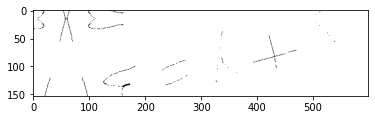

In [29]:
plt.imshow(augumentation(images[0]))

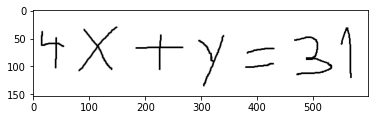

In [31]:
plt.imshow(images[0])

In [53]:
dictt={}
for key, value in dic.items():
    path = os.path.join('mathSymbolsDataset/', key)
    dictt.update(len(os.listdir(path)))

[47,
 258,
 477,
 556,
 558,
 693,
 973,
 1536,
 2332,
 2689,
 2742,
 2796,
 2909,
 3068,
 3118,
 3251,
 3545,
 3737,
 5140,
 5870,
 6914,
 7396,
 9340,
 10909,
 13104,
 14294,
 14355,
 25112,
 26141,
 26520,
 26594,
 33997]

In [ ]:
from sklearn.utils import resample

braket_upsampled = resample(,
                          replace=True, # sample with replacement
                          n_samples=len(), # match number in majority class
                          random_state=27) # reproducible results


In [45]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(2025, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(2025, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(32, activation=tf.nn.softmax))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])
model.fit(x_train, y_train_nums, epochs=5)

Epoch 1/5
1912/1912 [==============================] - 99s 51ms/step - loss: 2.9547 - accuracy: 0.1284
Epoch 2/5
1912/1912 [==============================] - 91s 47ms/step - loss: 2.3326 - accuracy: 0.2792
Epoch 3/5
1912/1912 [==============================] - 91s 48ms/step - loss: 2.1447 - accuracy: 0.3309
Epoch 4/5
1912/1912 [==============================] - 98s 51ms/step - loss: 2.0529 - accuracy: 0.3606
Epoch 5/5
1912/1912 [==============================] - 105s 55ms/step - loss: 1.9897 - accuracy: 0.3784


In [51]:
print(np.argmax(model.predict(symbols[5].reshape(1,45,45))))

25


In [55]:
x_train.classes

AttributeError: 'numpy.ndarray' object has no attribute 'classes'

In [ ]:
max_val = lst[-1]      
class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}                     
